/tmp/ipykernel_24498/432401826.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,7)) #create figure


<Figure size 720x504 with 0 Axes>

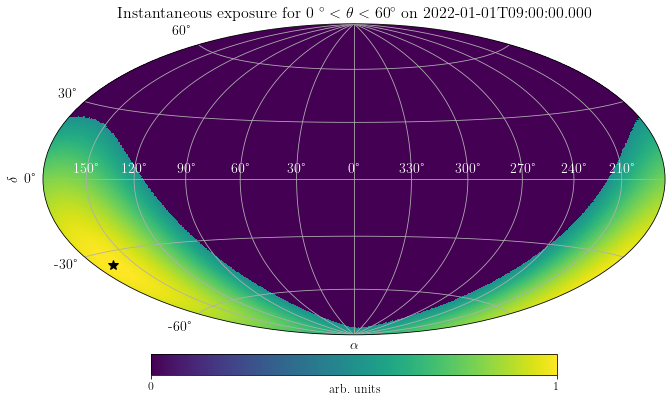

<Figure size 720x504 with 0 Axes>

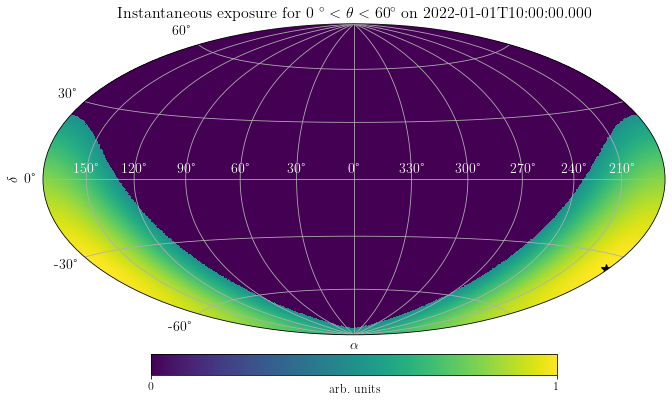

<Figure size 720x504 with 0 Axes>

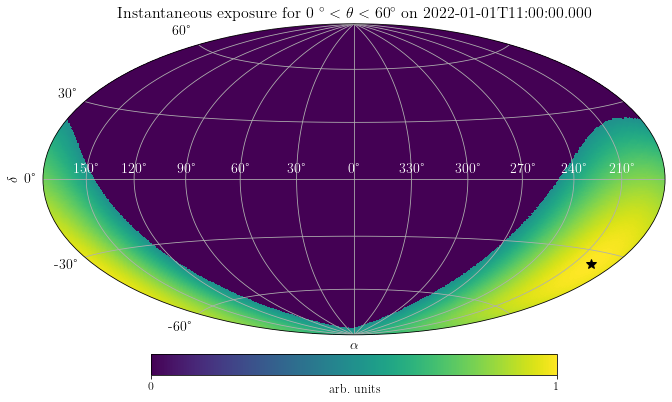

<Figure size 720x504 with 0 Axes>

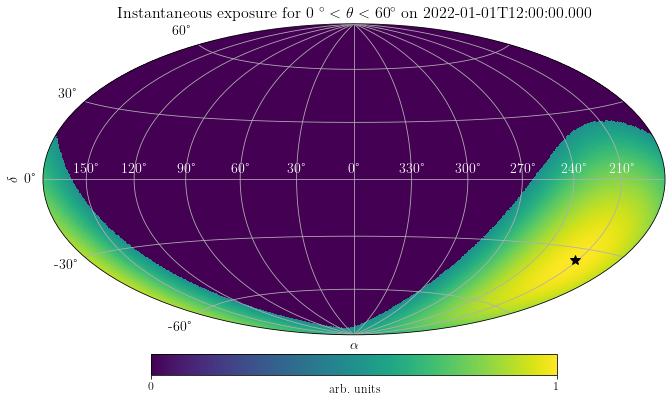

<Figure size 720x504 with 0 Axes>

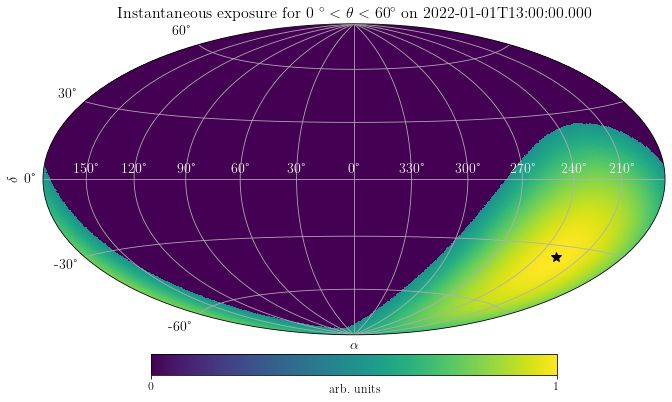

<Figure size 720x504 with 0 Axes>

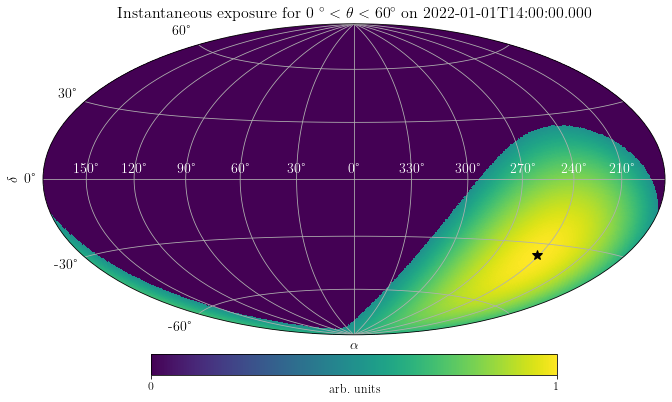

<Figure size 720x504 with 0 Axes>

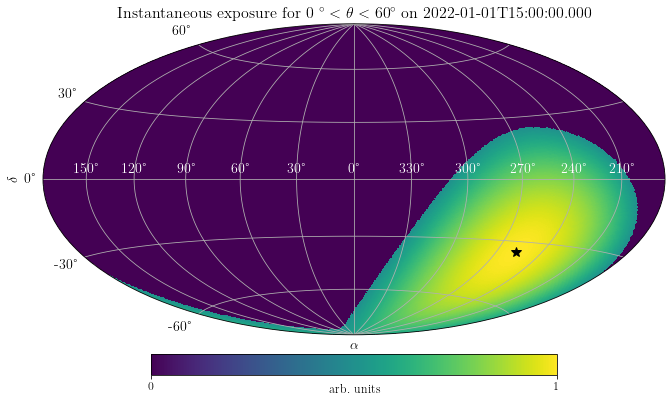

<Figure size 720x504 with 0 Axes>

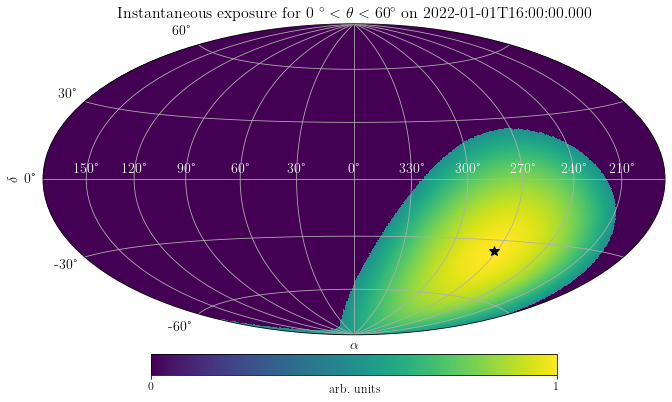

<Figure size 720x504 with 0 Axes>

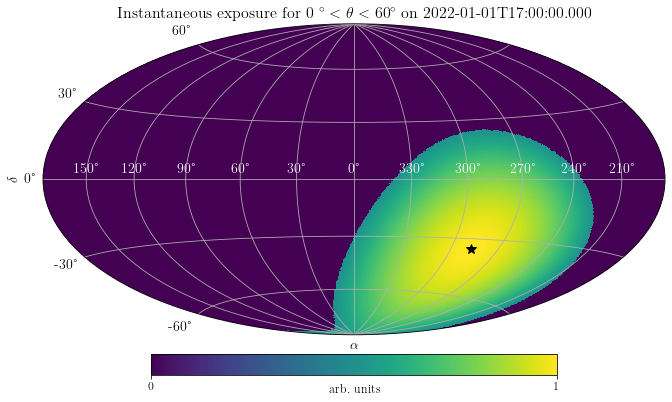

<Figure size 720x504 with 0 Axes>

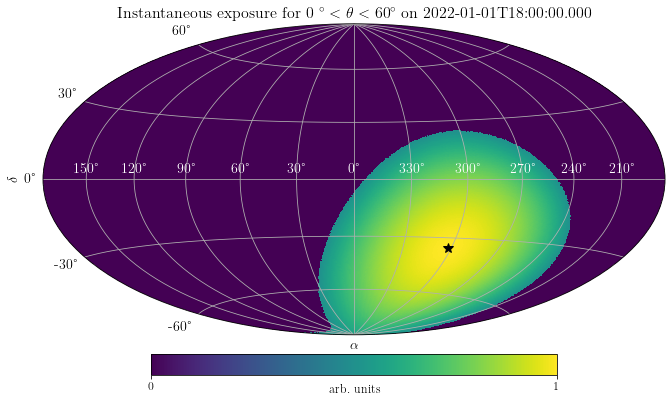

<Figure size 720x504 with 0 Axes>

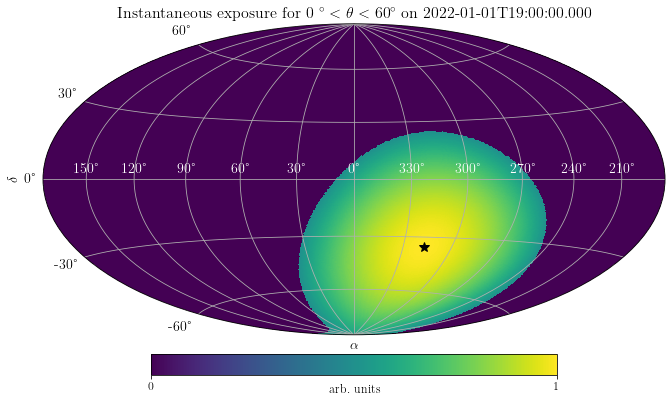

<Figure size 720x504 with 0 Axes>

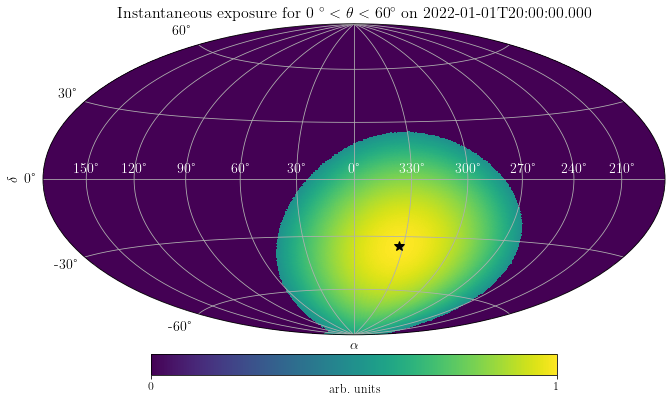

<Figure size 720x504 with 0 Axes>

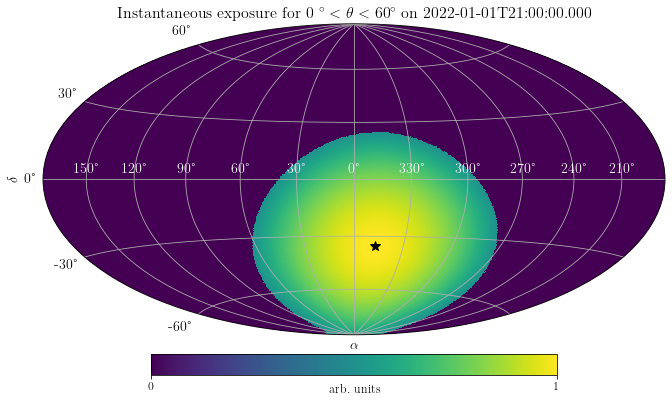

<Figure size 720x504 with 0 Axes>

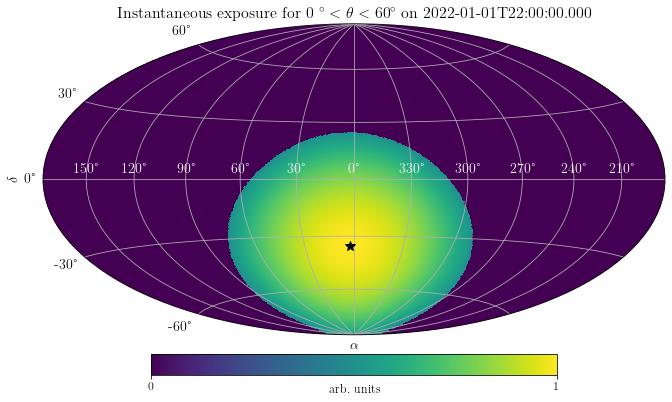

<Figure size 720x504 with 0 Axes>

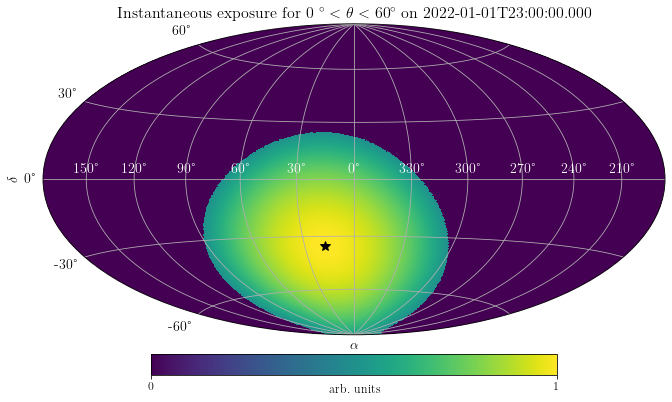

In [16]:
#---------------------------------------
# Try optimize the code!!!!
#---------------------------------------
import math
import numpy as np 
import healpy as hp
from healpy.newvisufunc import projview, newprojplot

#for plotting 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

#to import and work with data frames 
import pandas as pd

#to work with time and angular coordinates in the celeastial sphere
from astropy.time import Time
import astropy.units as u

%matplotlib inline

rc('font',**{'family':'serif','serif':['DejaVu Sans']})
rc('text', usetex=True)

#convert a set of pandas columns into a list of event 
def pandas_to_event(df, str1 , str2, str3, str4):
    
    alpha = df[str1].to_numpy()
    delta = df[str2].to_numpy()
    time = df[str3].to_numpy()
    energy = df[str4].to_numpy()
    
    evt_list = []
    
    for i in range(len(alpha)):
        evt_list.append([alpha[i],delta[i],time[i],energy[i]])
        
    return evt_list

#convert equatorial coordinates of event into healpy coordinates 
def Healpy_Event(evt_list):
        
    new_evt_list = []
    
    for evt in evt_list:
        evt[1] = math.pi/2 - evt[1]
        new_evt_list.append(evt)
    
        
    return new_evt_list

#convert equatorial coordinates into healpy coordinates 
def ToHealpyCoordinates(alpha, dec):
    
    return alpha, np.pi/2 - dec

#convert healpy coordinates into Equatorial Coordinates
def ToEquatorialCoordinates(phi, theta):
    
    return phi, np.pi/2 - theta

#compute exposure per solid angle per unit time 
def InstantExposure(l, delta, alpha, LST):
    
    return math.cos(l)*math.cos(delta)*math.cos(LST - alpha) + math.sin(l)*math.sin(delta) 

#exposure map
def InstantExposureMap(NSIDE, theta_min, theta_max, lat, LST):
    
    #number of pixels
    NPIX = hp.nside2npix(NSIDE)
    
    #theta and phi lists
    theta, phi = [], []
    
    #position of PAO observatory in celestial sphere
    phi_pao = LST
    theta_pao = math.pi/2 - lat
    
    pos = hp.ang2vec(theta_pao,phi_pao)
    
    #define the field of view of the observatory
    outer_disc_indexes = hp.query_disc(NSIDE,vec=pos,radius=theta_max)
    inner_disc_indexes = hp.query_disc(NSIDE,vec=pos,radius=theta_min)
    
    #saves theta and phi values corresponding to each pixel
    for i in range(NPIX):
        theta.append(hp.pix2ang(NSIDE,i)[0])
        phi.append(hp.pix2ang(NSIDE,i)[1])
    
    alpha, delta = ToEquatorialCoordinates(np.array(phi), np.array(theta))
            
    #vector with index positions in healpy sky_map given theta and phi
    map_indexes = hp.ang2pix(NSIDE,theta,phi)
    
    #fill vector with size NPIX and all entries to 0
    exposure_map = np.zeros(NPIX)
    
    #do this in a cleverer way!!!!
    for i in range(NPIX):
        if (i in outer_disc_indexes and i not in inner_disc_indexes):          
            exposure_map[i] = InstantExposure(lat,delta[i],alpha[i],LST)
    
    
    return exposure_map

#-------------------------------
# main 
#-------------------------------

#latitude and longitude of PAO
lat_pao = math.radians(-35.28)
long_pao = math.radians(-69.2)

#array with hours of the day 
hour_array = np.arange(9,24,1)

#define the values of theta max and theta_min for the relative exposure
theta_max = math.radians(60)
theta_min = math.radians(0)

#define the angular resolution of the map 
NSIDE = 128

for hour in hour_array:
    
    if hour < 10:
        str_hour = '0' + str(hour)
    else:
        str_hour = str(hour)
    
    #apparent sidereal time of the observatory for a given date  
    t = Time('2022-01-01T' + str_hour + ':00:00.0', format='fits', scale='utc',location=(long_pao*u.rad,lat_pao*u.rad))

    sidereal_t = t.sidereal_time('apparent').rad
    
    #create figure
    fig = plt.figure(figsize=(10,7)) #create figure

    #plot sky map 
    projview(
        InstantExposureMap(NSIDE,theta_min,theta_max,lat_pao,sidereal_t),
        graticule=True,
        graticule_labels=True,
        title=r"Instantaneous exposure for {%.0f} $^\circ < \theta < {%.0f}^\circ$ on %s" % (math.degrees(theta_min), math.degrees(theta_max), str(t.fits)),
        unit="arb. units",
        xlabel=r"$\alpha$",
        ylabel=r"$\delta$",
        cb_orientation="horizontal",
        override_plot_properties={'figure_width':10, 'figure_size_ratio':0.6},
        projection_type="hammer",
        fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
        longitude_grid_spacing = 30,
        latitude_grid_spacing = 30,
        xtick_label_color='white'
    )
    
    #convert sidereal time into phi
    if sidereal_t < math.pi:
        phi_value = sidereal_t
    else:
        phi_value = sidereal_t - 2*math.pi
        
    #draw the position of the PAO in the sky over time
    newprojplot(theta=math.pi/2 - lat_pao, phi=phi_value, marker="*", color="black", markersize=10);

    plt.savefig('./results/Instantaneous_exposure_' + '2022-01-01T' + str_hour + ':00:00.0' + '.pdf',dpi=500)

